# Modelling

In [ ]:
def confusion_mat(test_y,predict_y):
    ''' Function to Visualize the Confusion Matrix'''

    labels = [0,1]
    plt.figure(figsize=(6,6))
    cmap=sns.light_palette("blue")
    C = confusion_matrix(test_y, predict_y)
    print("Percentage of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    sns.heatmap(C, cmap="Blues",annot=True,annot_kws={"size": 16},fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Confusion matrix')

    plt.show()

#Xgboost Classifier

In [ ]:
weight=Counter(y_train)    #To Compensate for the imbalance in the dataset we use scale_pos_weight it has  the effect of weighing the balance of positive examples, relative to negative examples when boosting decision trees.
weight=weight[0]/weight[1]
print(weight)

10.0


### XGBoost using RandomizedCV hyperparameter tuning

In [ ]:
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

x_cfl=XGBClassifier(scale_pos_weight=10)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,scoring='f1',n_jobs=-1)
random_cfl1.fit(X_train,y_train)
print("The best Hyperparameters are ",'\n')
print(random_cfl1.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 39.1min finished


{'subsample': 1, 'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 0.5}



 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data 1.0
F1_score for cv data 0.7929515418502203
F1_score for test data 0.8216216216216216
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.0


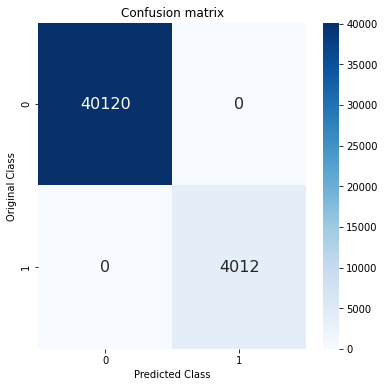

****************************************************************************************************
Confusion Matrix for the Test Data  

Percentage of misclassified points  0.5499999999999999


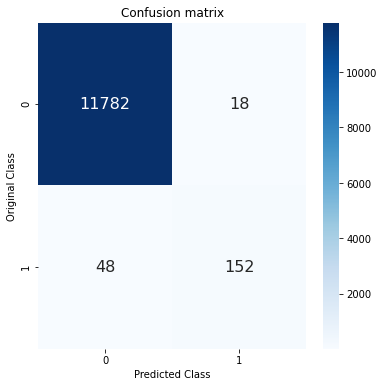

****************************************************************************************************


In [ ]:
x_cfl=XGBClassifier(n_estimators=2000,subsample=1,max_depth=5,learning_rate=0.03,colsample_bytree=0.5,scale_pos_weight=10,n_jobs=-1)
x_cfl.fit(X_train, y_train)
c_cfl1 = CalibratedClassifierCV(x_cfl, method="isotonic")
c_cfl1.fit(X_train,y_train)


predict_y_train = c_cfl1.predict(X_train)
print ('train F1_score',f1_score(y_train,predict_y_train,average='binary'))
predict_y = c_cfl1.predict(X_cv)
print ('cv F1_score',f1_score(y_cv, predict_y,average='binary'))
predict_y_test = c_cfl1.predict(X_test)
print ('test F1_Score',f1_score(y_test, predict_y_test,average='binary'))
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,predict_y_train)
print('*'*100)
print("Confusion Matrix for the Test Data ",'\n')
confusion_mat(y_test,predict_y_test)
print('*'*100)

### XGBoost using cross validation dataset for hyperparameter tuning


F1 score for : 10 is 0.5081967213114754 
F1 score for : 50 is 0.5674157303370787 
F1 score for : 100 is 0.6329113924050633 
F1 score for : 500 is 0.7698412698412699 
F1 score for : 1000 is 0.7868852459016393 

  Best alpha (hyperparameter) : 1000 



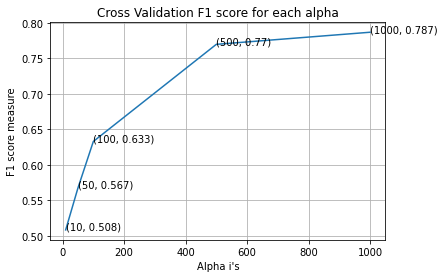


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data 1.0
F1_score for cv data 0.7868852459016393
F1_score for test data 0.8290155440414508


In [ ]:
#choosing the best hyperparameters

from collections import Counter
c1=Counter(y_train)
c=c1[0]/c1[1]

alpha=[10,50,100,500,1000]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1,scale_pos_weight=c)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_XGB = np.argmax(cv_f1score_array)

print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_XGB]  ,'\n')
#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots()

#plotting hyperparameter V/S F1score
ax.plot(alpha, cv_f1score_array)
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
x_cfl=XGBClassifier(n_estimators=alpha[best_alpha_XGB],nthread=-1,scale_pos_weight=c)
x_cfl.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

#predicting actual labels
pred_y=sig_clf.predict(X_test)

#displaying the perfomance metric for train,cv and test data

print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train =sig_clf.predict(X_train)
print ('F1 score for train data',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = sig_clf.predict(X_cv)
print ('F1_score for cv data',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = sig_clf.predict(X_test)
print ('F1_score for test data',f1_score(y_test, pred_y_test, average='binary'))



****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.0


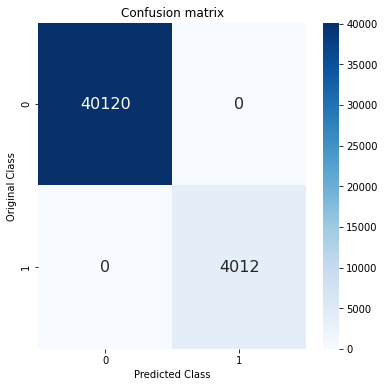

****************************************************************************************************
Confusion Matrix for the Test Data  

Percentage of misclassified points  0.5499999999999999


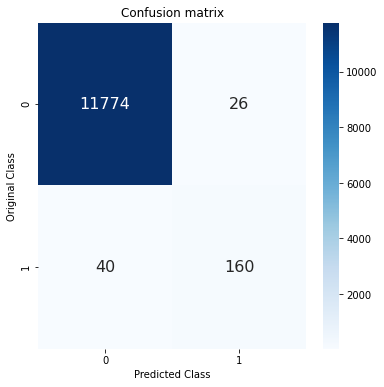

****************************************************************************************************


In [ ]:
predict_y_train = sig_clf.predict(X_train)
predict_y = sig_clf.predict(X_cv)

predict_y_test = sig_clf.predict(X_test)

print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,predict_y_train)
print('*'*100)
print("Confusion Matrix for the Test Data ",'\n')
confusion_mat(y_test,predict_y_test)
print('*'*100)

### XGBoost on important features

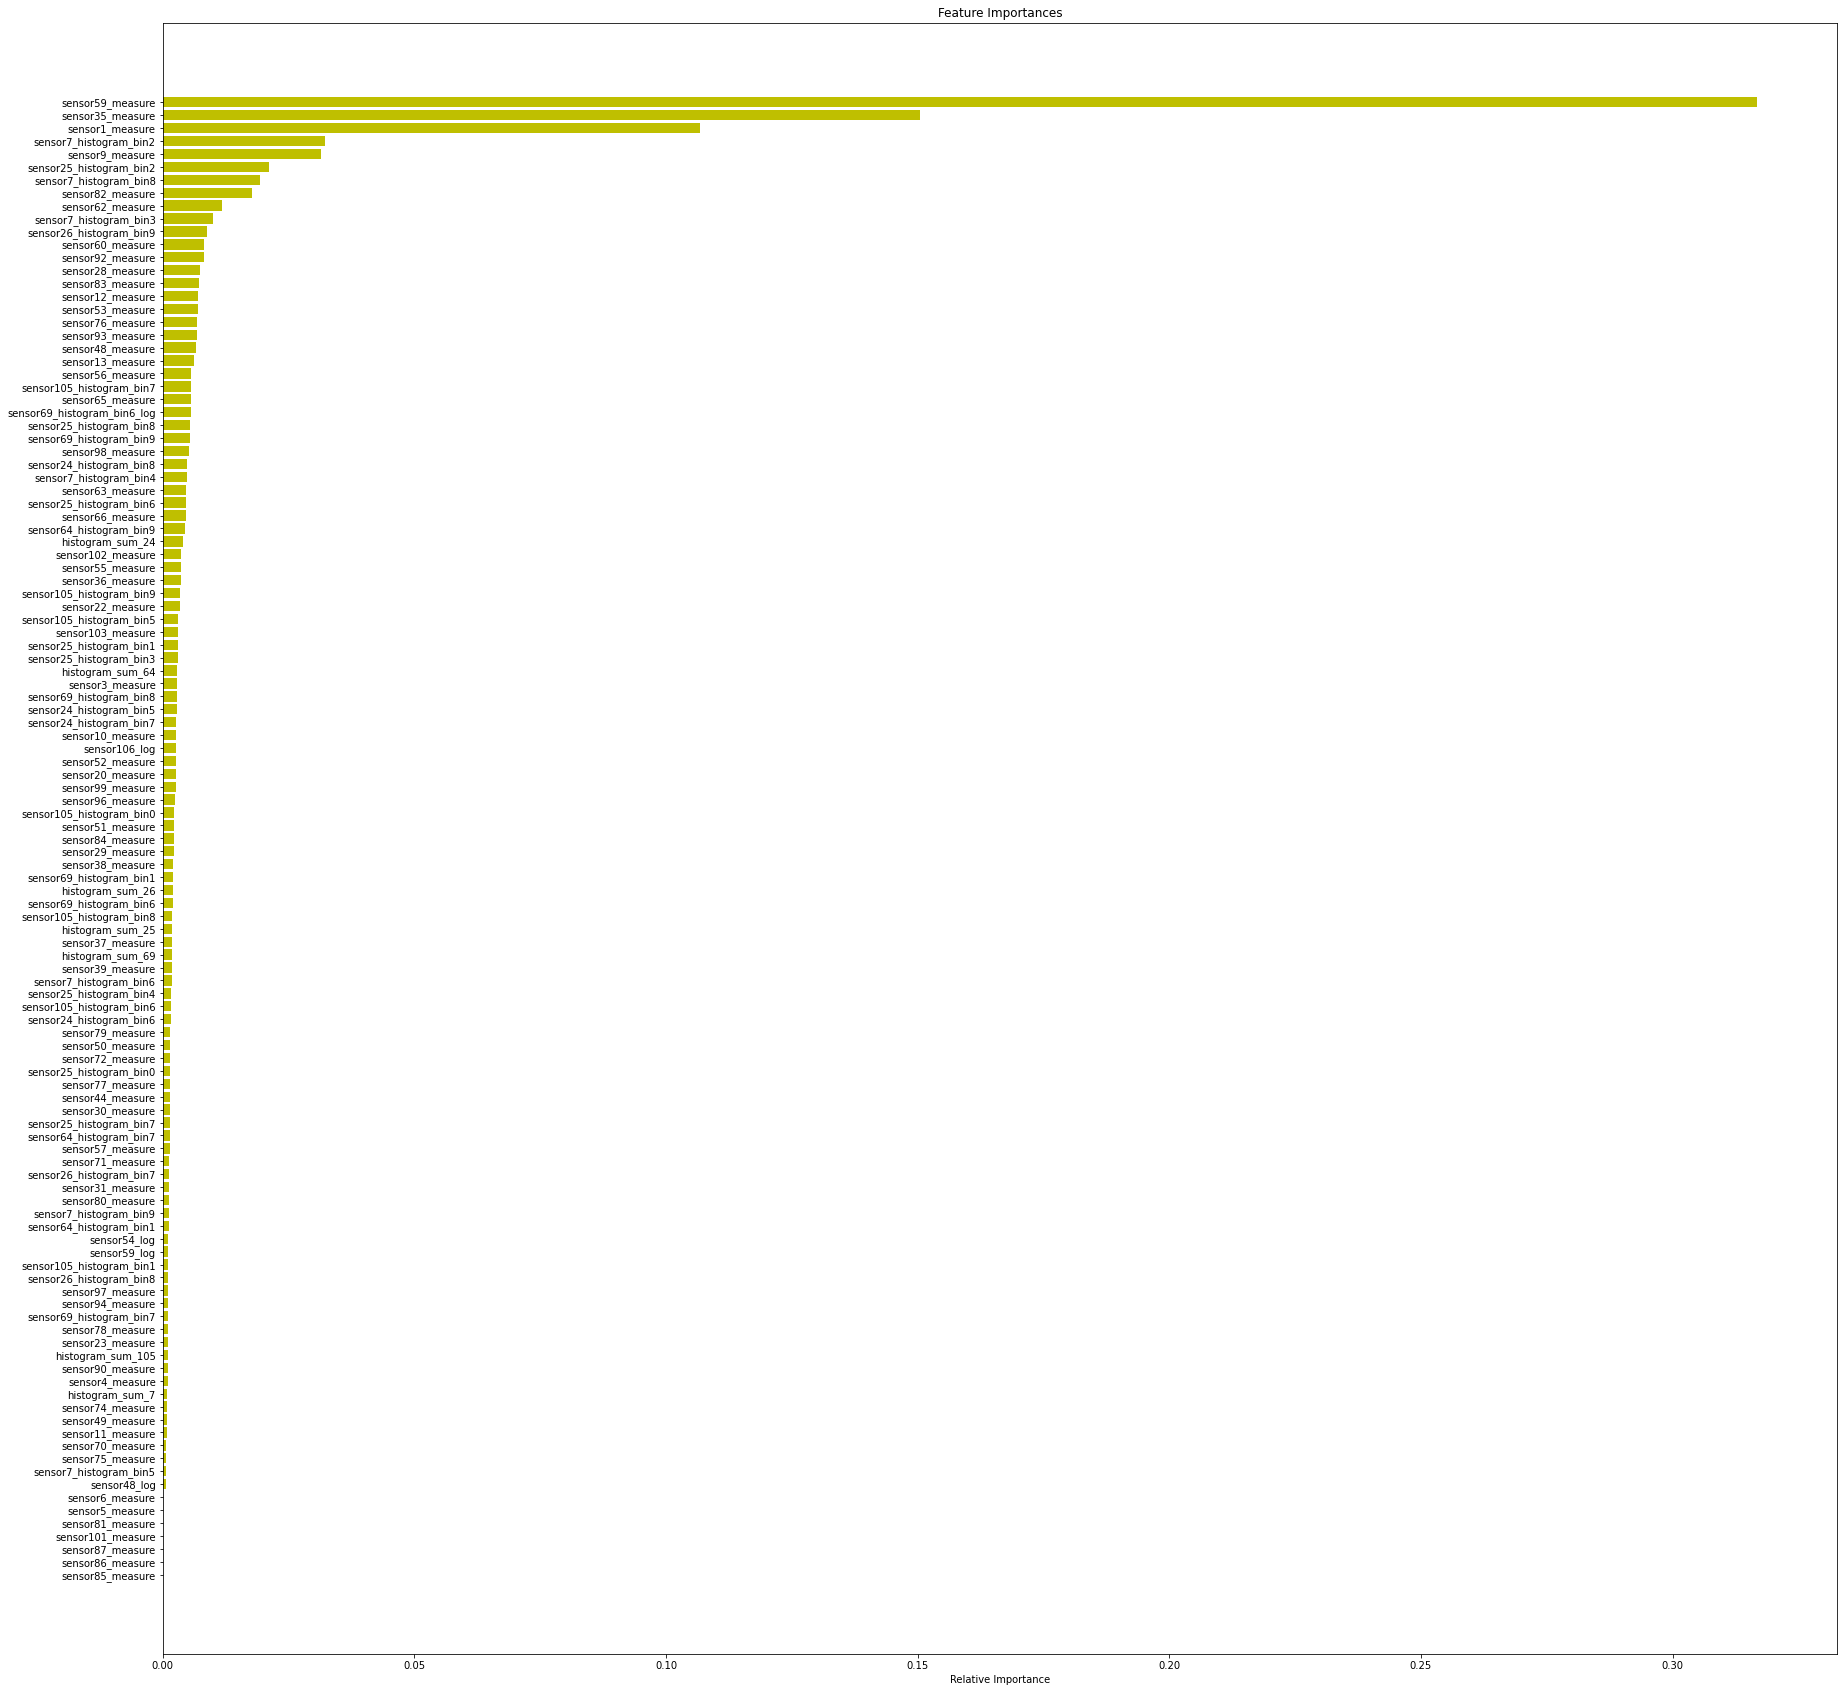

In [ ]:
#feature importance for XGBOOST
features = X_train.columns
importances = x_cfl.feature_importances_
indices = (np.argsort(importances))
plt.figure(figsize=(30,30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='y', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
features = X_train.columns
importances = x_cfl.feature_importances_
indices = (np.argsort(importances))[:45]            #There are many features with insignificant importance. We shall be dropping the least 45 important features
redundant=[]
for i in indices:
    redundant.append(features[i])

#removing the least important features.
X_train_XGB=X_train.drop(rem_feat,axis=1)
X_cv_XGB=X_cv.drop(rem_feat,axis=1)
X_test_XGB=X_test.drop(rem_feat,axis=1)


F1 score for : 10 is 0.5068119891008174 
F1 score for : 50 is 0.5617977528089888 
F1 score for : 100 is 0.6496815286624205 
F1 score for : 500 is 0.7826086956521738 
F1 score for : 1000 is 0.8083333333333333 

  Best alpha (hyperparameter) : 1000 



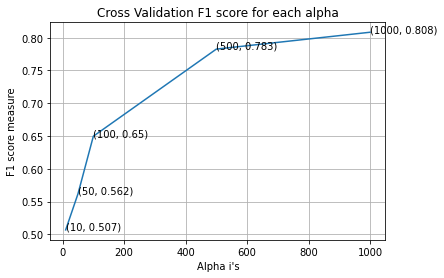


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data 1.0
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.0


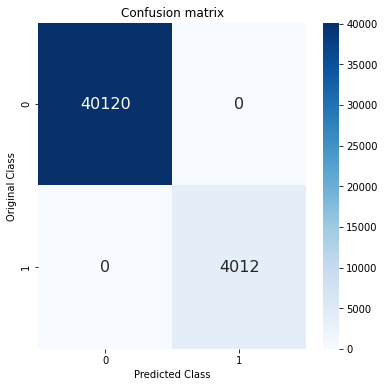

F1_score for cv data 0.8083333333333333
F1_score for test data 0.8103896103896104
****************************************************************************************************
Confusion Matrix for the Train Data  

Percentage of misclassified points  0.6083333333333333


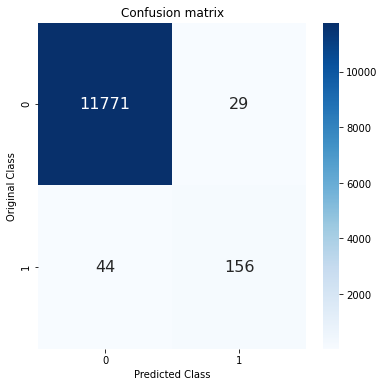

In [ ]:
#choosing the best hyperparameters


alpha=[10,50,100,500,1000]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1,scale_pos_weight=c)
    x_cfl.fit(X_train_XGB,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_XGB, y_train)
    predict_y = sig_clf.predict(X_cv_XGB)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_XGB = np.argmax(cv_f1score_array)

print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_XGB]  ,'\n')
#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots()

#plotting hyperparameter V/S F1score
ax.plot(alpha, cv_f1score_array)
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
x_cfl=XGBClassifier(n_estimators=alpha[best_alpha_XGB],nthread=-1,scale_pos_weight=c)
x_cfl.fit(X_train_XGB, y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_XGB, y_train)

#predicting actual labels
pred_y=sig_clf.predict(X_test_XGB)

#displaying the perfomance metric for train,cv and test data

print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train =sig_clf.predict(X_train_XGB)
print ('F1 score for train data',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = sig_clf.predict(X_cv_XGB)
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_train,pred_y_train)
print ('F1_score for cv data',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = sig_clf.predict(X_test_XGB)
print ('F1_score for test data',f1_score(y_test, pred_y_test, average='binary'))
print('*'*100)
print("Confusion Matrix for the Train Data ",'\n')
confusion_mat(y_test,pred_y_test)